In [11]:
%%capture

# Cell for Google Colab. Setup takes ~30 sec.
try:
    import google.colab
    import os

    !git clone https://gitlab.com/sigcorr/sigcorr.git

    os.chdir("sigcorr")

    !sed -i 's/>=3.9/>=3.7/g' setup.cfg
    !sed -i 's/from collections.abc import Iterable/from typing import Iterable/g' sigcorr/tools/utils.py
    !pip install .
    !./docs/src/setup.sh


    os.chdir("notebooks")
except ImportError:
    # not running inside the Colab
    pass

In [2]:
%matplotlib inline

import h5py
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipw
plt.rcParams["figure.figsize"] = (12, 8)

# 1. Exploring MC samples from the Hyy inspired model 

This tutorial is based on a toy model inspired by Higgs diphoton decay searches. We model background shape as an exponential distribution:

$b(m) = b_0 \exp{\left(-\frac{m - 100}{\delta_x}\right)}$

We collected all the information about the statistical model (together with the truth information) in the `Hyy` class.

Let's import it and try to sample several background samples.

First we define the `sampling_grid` and instantiate the model. Then we use `get_bg_samples` method to generate 10 `bg_samples`.

We assume errors on the data are Gaussian:

In [3]:
from sigcorr.models.hyy import Hyy

sampling_grid = np.arange(100, 160.01, 1.).reshape(-1, 1)  # 100-160 GeV with 1 GeV step
hyy = Hyy(sampling_grid).init()
bg_samples = hyy.get_bg_samples(10)

print("We print the shape of the output. It contains 10 background toys with 61 bins of MC data each")
print("Output shape: ", bg_samples.shape)

We print the shape of the output. It contains 10 background toys with 61 bins of MC data each
Output shape:  (10, 61)


True values of $b_0$ and $\delta_x$ are stored in `B0` and `BG_XSCALE` and we can use them to plot the background shape together with the data sample.
The background shape itself is stored in the `expected_b` method.

In [4]:
def _plot_bg_samples(i):
    expected_b = hyy.expected_b(hyy.B0, hyy.BG_XSCALE)
    error = hyy.BG_NOISE_STD
    plt.fill_between(hyy.xs,  expected_b - error, expected_b + error, label="1 sigma", color="lightgray")
    plt.plot(hyy.xs, expected_b, label="expected b")
    plt.scatter(hyy.xs, bg_samples[i], label="brute force")
    plt.xlabel("m, GeV")
    plt.ylabel("N, num events")
    plt.legend()
ipw.interact(_plot_bg_samples, i=(0, bg_samples.shape[0]-1, 1));

interactive(children=(IntSlider(value=4, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

# 2. Asimov set of samples for the Hyy inspired model

Asimov set of background samples - a carefully chosen set of samples, that when fitted, can well approximate the covariance structure of the local significance fluctuations.

Technically, it is just the same set of methods / parameters as the `Hyy` model, but the method `get_bg_samples` is modified to reflect the Asimov procedure for the covariance described in the paper: https://arxiv.org/abs/2206.12328

Let's sample Asimov samples and visualize them together with the background shape:

In [5]:
from sigcorr.models.hyy_asimov import HyyAsimov
hyy_asimov = HyyAsimov(sampling_grid).init()
bg_samples_asimov = hyy_asimov.get_bg_samples(None)

In [6]:
def _plot_bg_samples_asimov(i):
    expected_b = hyy.expected_b(hyy.B0, hyy.BG_XSCALE)
    error = hyy.BG_NOISE_STD
    plt.fill_between(hyy.xs,  expected_b - error, expected_b + error, label="1 sigma", color="lightgray")
    plt.plot(hyy.xs, expected_b, label="expected b")
    plt.scatter(sampling_grid, bg_samples_asimov[i], label=f"Asimov sample {i}")
    plt.xlabel("m, GeV")
    plt.ylabel("N, num events")
    plt.legend()
ipw.interact(_plot_bg_samples_asimov, i=(0, bg_samples_asimov.shape[0]-1, 1));

interactive(children=(IntSlider(value=30, description='i', max=60), Output()), _dom_classes=('widget-interact'…

# 3. Exploring the signal model

We chose a signal model as a Gaussian peak with fixed width (stored in `hyy.SIG_STD`), strength `mu` (that is 0 for the background hypothesis) and undetermined location.

Signal strength `mu` takes part in the fits and is the only fitted parameter of the signal model.

Signal location is set fixed during the fits. We expect, therefore, the test statistic built from the likelihood ration to follow the $\chi^2$ distribution with 1 d.o.f.

Let's plot the s+b model.

In [7]:
def _plot_sb_shape(i, mu):
    plt.plot(sampling_grid, hyy.expected_b(hyy.B0, hyy.BG_XSCALE), label="expected b")
    plt.plot(sampling_grid, hyy.expected_sb(sampling_grid[i], [mu], [hyy.B0, hyy.BG_XSCALE]), label="expected s+b")
    plt.xlabel("m, GeV")
    plt.ylabel("N, num events")

ipw.interact(_plot_sb_shape, i=(0, sampling_grid.shape[0]-1, 1), mu=(-30, 30, 3));

interactive(children=(IntSlider(value=30, description='i', max=60), IntSlider(value=0, description='mu', max=3…

**Trials factor** appears when we try to find the location on the mass range where the signal model fit yields the most signal.

The p-value that we calculate is the local p-value. To find the local p-value we do a lot of statistical tests of the same model on relatively different data samples.

This suggests, by analogy with the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction), that the correct p-value ($p_{global}$) is bigger than the local p-value ($p_{local}$) by some factor that is called Trials Factor (TF): $TF = \frac{p_{global}}{p_{local}}$

Technically, the Trials factor is a proxy from $p_{local}$ to $p_{global}$ and is a function of $p_{local}$. To calculate the $p_{global}$ for some local significance $Z_{local}$, we need to compute the fraction of samples that exceeded $Z_{local}$ anywhere on the mass range.

This is our motivation to study the significance curves emerging from the likelihood scans along the mass range. Let's explore them!

# 4. Fits of the Asimov set of background samples. Test statistic

SigCorr also provides a fitting framework.

People usually know how they want to do fits, therefore, we will not focus on it in this tutorial.

We, however, provide the output file of the "fitter" that we prepared in advance. It contains:

* `bg_samples`
* Truth parameters like `B0` or `BG_XSCALE`
* Values of the log-likelihoods for b (`b_loglikes`) and s+b (`sb_loglikes`) fits
* Parameters that optimize these likelihoods (`b_params` and `sb_params`)
* Grids used for sampling (`sampling_xs`) and scanning (`scan_xs`).

Below we extract log-likelihoods for the background-only and background+signal hypotheses as well as the values of the fitted signal strength $\hat{\mu}$ (`sb_params`), and a set of points (`scan_xs`) at which we tested the signal peak.

In [12]:
asimov_fits = {}
with h5py.File("../docs/src/data/Asimov1D/hyy_tutorial.h5") as fin:
    asimov_fits["b_loglikes"] = fin["b_loglikes"][...]
    asimov_fits["sb_loglikes"] = fin["sb_loglikes"][...]
    asimov_fits["sb_params"] = fin["sb_params"][...]
    xs = fin["scan_xs"][...].ravel()

**Exercise 1**

From the log-likelihoods it is straightforward to construct the value of the test statistic (TS). Sigcorr has a function prepared for this: `get_delta_ts`.

The first task in this tutorial is to find the arguments that this function needs.

You will find the hints in [Visualization 1D](https://sigcorr.gitlab.io/sigcorr/dev/tutorial/visualization_1d.html) page of the documentation.

NOTE: the variables that need to be passed are already defined above.

In [13]:
from sigcorr.tools.stats.utils import get_delta_ts

asimov_ts = get_delta_ts(<blank>)

SyntaxError: invalid syntax (2575840531.py, line 3)

In [14]:
# answer
from sigcorr.tools.stats.utils import get_delta_ts

asimov_ts = get_delta_ts(asimov_fits["b_loglikes"], asimov_fits["sb_loglikes"])

When the blanks were filled, we can plot the test statistic curves for each Asimov sample 

In [15]:
def _plot_asimov_ts(i):
    plt.scatter(xs, asimov_ts[i], label=f"Asimov ts [{i}]")
    plt.xlabel("m, GeV")
    plt.ylabel("TS, test statistic")
    plt.legend()
ipw.interact(_plot_asimov_ts, i=(0, asimov_ts.shape[0]-1));

interactive(children=(IntSlider(value=30, description='i', max=60), Output()), _dom_classes=('widget-interact'…

# 5. (detour) Transition from the test statistic to significance. Brute force toys example

Since this tutorial is about the Gaussian process, we need to find a random variable that follows a Gaussian distribution.

$\chi^2$ with 1 d.o.f., [by definition](https://en.wikipedia.org/wiki/Chi-squared_distribution) is a distribution of a variable $t = Z^2$ where $Z \sim \mathcal{N}(0, 1)$.

Naivly, $Z = \sqrt{t}$ is almost $\sim \mathcal{N}(0, 1)$, we are missing the sign.

Briefly, the sign depends on whether the data around the bin fits better with excess (+) or a deficit (-).

More detailed and strict formulation of this fact is described in [Cowan et al.](https://doi.org/10.1140/epjc/s10052-011-1554-0), but for practical purposes the sign can be determined as $\mathrm{sign}(\hat{\mu})$, where $\hat{\mu}$ is the signal strength that maximizes the log-likelihood.

In SigCorr there is a special function that implements the transition from likelihoods to significances: [`get_delta_sig`](https://sigcorr.gitlab.io/sigcorr/-/blob/master/sigcorr/tools/stats/utils.py#L8)

We fitted a bunch of brute force samples and stored the fits in a similar `.h5` file to the one with Asimov fits described above:

In [16]:
fits = {}
with h5py.File("../docs/src/data/3K1D/hyy_tutorial.h5") as fin:
    fits["b_loglikes"] = fin["b_loglikes"][...]
    fits["sb_loglikes"] = fin["sb_loglikes"][...]
    fits["sb_params"] = fin["sb_params"][...]
    _xs = fin["scan_xs"][...].ravel()  # xs == _xs you can use them interchangeably. We put it here for completeness

We compute the test statistic similarly to Asimov fits, but also we compute the significances according to the procedure described above.

We provide the `sb_params` (that is $\hat{\mu}$) to `get_delta_sigs` as the third argument, this will be used to determine the sign.

In [17]:
from sigcorr.tools.stats.utils import get_delta_sigs

ts = get_delta_ts(fits["b_loglikes"], fits["sb_loglikes"])
sigs = get_delta_sigs(fits["b_loglikes"], fits["sb_loglikes"], fits["sb_params"][..., 0])

Let's plot the test statistic alongside with the significance curve for each sample.

Notice how the local minima and maxima of the significance correspond to peaks of the test statistic:

In [18]:
def _compare_ts_vs_sigs(i):
    fig, ax = plt.subplots(nrows=2)
    ax[0].scatter(xs, ts[i], label="test statistic")
    ax[0].legend()
    ax[0].set_xlabel("m, GeV")
    ax[0].set_ylabel("N, num events")
    ax[1].scatter(xs, sigs[i], label="significance")
    ax[1].legend()
    ax[1].set_xlabel("m, GeV")
    ax[1].set_ylabel("Z, local significance")
ipw.interact(_compare_ts_vs_sigs, i=(0, ts.shape[0]-1, 1));

interactive(children=(IntSlider(value=1499, description='i', max=2999), Output()), _dom_classes=('widget-inter…

# 6. Significance curve for Asimov background sample

**Exercise 2**

Compute the significances for Asimov sets by analogy with the brute force toys.

In [19]:
asimov_sigs = get_delta_sigs(<blank>)

SyntaxError: invalid syntax (2346820792.py, line 1)

In [20]:
# answer

asimov_sigs = get_delta_sigs(asimov_fits["b_loglikes"], asimov_fits["sb_loglikes"], asimov_fits["sb_params"][..., 0])

In [21]:
def _compare_asimov_ts_vs_sigs(i):
    fig, ax = plt.subplots(nrows=2)
    ax[0].scatter(xs, asimov_ts[i], label="Asimov test statistic")
    ax[0].legend()
    ax[0].set_xlabel("m, GeV")
    ax[0].set_ylabel("TS, test statistic")
    ax[1].scatter(xs, asimov_sigs[i], label="Asimov significance")
    ax[1].legend()
    ax[1].set_xlabel("m, GeV")
    ax[1].set_ylabel("Z, local significance")

ipw.interact(_compare_asimov_ts_vs_sigs, i=(0, asimov_ts.shape[0]-1, 1));

interactive(children=(IntSlider(value=30, description='i', max=60), Output()), _dom_classes=('widget-interact'…

# 7. Covariance matrix from significance curves

From the properties of the significance under the null hypothesis, it follows that each point of the significance curve is a standard normal random variable.

Entire curve, when observed on a grid, is a realization of some multivariate gaussian distribution.

By construction it has mean 0 and standard deviation 1. The latter means that the diagonal of the covariance matrix is 1.

If we manage to estimate the non-diagonal terms of the covariance, we will be able to produce new significance curves without making fits to the data.

In SigCorr we implemented a simple class to work with sample statistics. It allows to compute averages and covariances on a big sample while allowing to provide the input in batches (batches of significance curves in our case). Batched input doesn't matter for estimating the covariance, but in future, to estimate the trials factor from GP one would need millions of toys, and there is no reason to keep all of them in RAM.

In [22]:
from sigcorr.tools.stats.batch_stats import BatchStats2

bs = BatchStats2(sigs.shape[0], sigs.shape[1])  # BatchStats2(number_of_samples, shape_of_one_sample) 
bs.push(sigs)  # submit a batch. in our case we submit all curves we have in one batch
cov = bs.get_cov()  # extract the covariance matrix

print("We print the covariance shape that should have the dimension of the scanning grid on both axes")
print("Covariance shape: ", cov.shape)

We print the covariance shape that should have the dimension of the scanning grid on both axes
Covariance shape:  (61, 61)


**Exercise 3**

Below we suggest a template for Asimov covariance calculation, and the exercise is to fill in the blanks. Two major changes:

* We compute the correlation matrix instead of the covariance. This is to ensure that standard deviations are 1.
* We enforce zero mean when computing the covariance. This basically changes the definition of the covariance from $\mathrm{cov} (X, Y) =  E \left\{(X - \bar{X})(Y - \bar{Y})\right\}$ to $\mathrm{cov} (X, Y) =  E \left\{ X \cdot Y \right\}$

In [23]:
asimov_bs = BatchStats2(<blank>, <blank>)  # BatchStats2(number_of_samples, shape_of_one_sample) 
asimov_bs.push(<blank>)  # submit a batch. in our case we submit all curves we have in one batch
asimov_cov = asimov_bs.get_corr(override_x=np.array(0.))  # extract the covariance matrix

print("We print the Asimov covariance shape that should have the same dimension as the scanning grid for the Asimov samples:")
print(asimov_cov.shape)

SyntaxError: invalid syntax (2729507838.py, line 1)

In [24]:
# answer

asimov_bs = BatchStats2(asimov_sigs.shape[0], asimov_sigs.shape[1])  # BatchStats2(number_of_samples, shape_of_one_sample) 
asimov_bs.push(asimov_sigs)  # submit a batch. in our case we submit all curves we have in one batch
asimov_cov = asimov_bs.get_corr(override_x=np.array(0.))  # extract the covariance matrix

print("We print the Asimov covariance shape that should have the same dimension as the scanning grid for the Asimov samples:")
print(asimov_cov.shape)

We print the Asimov covariance shape that should have the same dimension as the scanning grid for the Asimov samples:
(61, 61)


Let's plot the covariances for comparison. Here `bf` referes to the brute force toys we generated above.

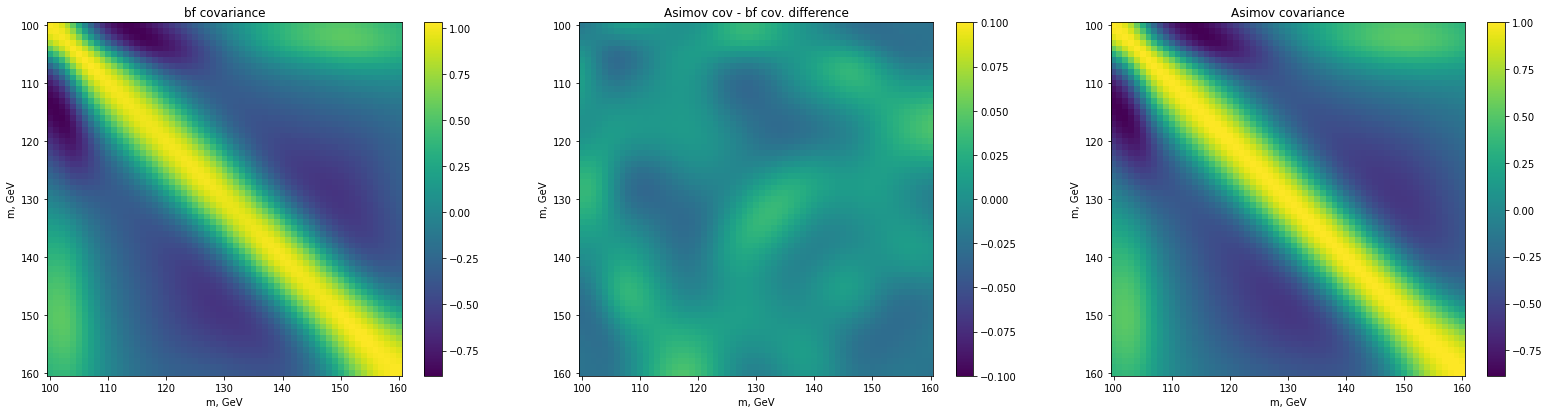

In [25]:
def _plot_cov_cmp():
    fig, ax = plt.subplots(ncols=3, figsize=(27, 6.5))
    mesh = ax[0].pcolormesh(xs, xs, cov)
    ax[0].set_title("bf covariance")
    ax[0].invert_yaxis()
    ax[0].set_xlabel("m, GeV")
    ax[0].set_ylabel("m, GeV")
    plt.colorbar(mesh, ax=ax[0])
    mesh = ax[1].pcolormesh(xs, xs, asimov_cov - cov, vmin=-0.1, vmax=0.1)
    ax[1].set_title("Asimov cov - bf cov. difference")
    ax[1].invert_yaxis()
    ax[1].set_xlabel("m, GeV")
    ax[1].set_ylabel("m, GeV")
    plt.colorbar(mesh, ax=ax[1])
    mesh = ax[2].pcolormesh(xs, xs, asimov_cov)
    ax[2].set_title("Asimov covariance")
    ax[2].invert_yaxis()
    ax[2].set_xlabel("m, GeV")
    ax[2].set_ylabel("m, GeV")
    plt.colorbar(mesh, ax=ax[2])
    
_plot_cov_cmp()

# 8. Global p-value calculation and Trials factor

Global p-value is the the main component of the Trials factor, it is the fraction of samples that exceed the local significance threshold anywhere on the mass range.

We can use Asimov covariance matrix to sample millions (let's start with 1M) toy significance curves and estimate the global p-value.

In [26]:
from sigcorr.tools.stats.gp.sampling import draw_gp_svd

gp_asimov_sigs = draw_gp_svd(asimov_cov, 1_000_000)  # sample 1M samples from a multivariate Gaussian distribution with Asimov covariance and mean 0

print("We print the shape of the generated samples. There should be 1M samples with 61 bins of the GP data each.")
print("Asimov GP samples shape: ", gp_asimov_sigs.shape)

We print the shape of the generated samples. There should be 1M samples with 61 bins of the GP data each.
Asimov GP samples shape:  (1000000, 61)


We would like to study the functional dependence of the trials factor, and, therefore, global p-value, on the local significance.

Let's agree on the grid of local significances on which we will map out the trials factor, and limit the grid to 0-4 $\sigma$ local significances, with a step of $0.1\sigma$:

In [27]:
LOCAL_SIG_GRID = np.arange(0, 4.01, 0.1)
LOCAL_SIG_GRID

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. ])

We prepared a function in SigCorr that for each curve returns an array of flags, one True/False value per local significance threshold.

This is basically an indicator function for the global p-value for every local significance threshold.

To get an estimate for the global p-value we need to take average along the axis enumerating the different significance curves.

In [28]:
from sigcorr.tools.overflows import overflows_along_zero_ax

asimov_p_global = overflows_along_zero_ax(gp_asimov_sigs, LOCAL_SIG_GRID).mean(axis=0)

Trials factor then is just a ratio $\mathrm{TF} = \frac{p_{global}}{p_{local}}$.

We need to convert significance grid into p-values. We will use a simple wrapper `sig2pval` from SigCorr.

In [29]:
from sigcorr.tools.stats.utils import sig2pval

p_local = sig2pval(LOCAL_SIG_GRID)

With $p_{local}$ we then compute the estimate for the trials factor from Asimov set of background samples:

In [30]:
asimov_tf = asimov_p_global/p_local

**Exercise 4**

Repeat the TF calculation for brute force toys. Remember that we stored the significance curves for the brute force toys in `sigs`. Fill in the gaps:

In [31]:
p_global = overflows_along_zero_ax(<blank>, <blank>).mean(axis=0)
tf = p_global/p_local

SyntaxError: invalid syntax (1868273035.py, line 1)

In [33]:
# answer

p_global = overflows_along_zero_ax(sigs, LOCAL_SIG_GRID).mean(axis=0)
tf = p_global/p_local

Comparison of the trials factor estimates from the Asimov set of samples and from a small amount of brute force toys:

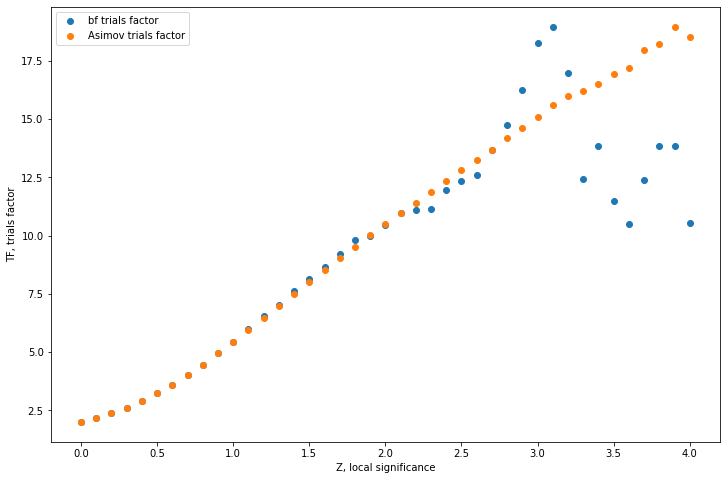

In [34]:
def _plot_tf_cmp_1():
    plt.scatter(LOCAL_SIG_GRID, tf, label="bf trials factor")
    plt.scatter(LOCAL_SIG_GRID, asimov_tf, label="Asimov trials factor")
    plt.xlabel("Z, local significance")
    plt.ylabel("TF, trials factor")
    plt.legend()
_plot_tf_cmp_1()

# 9. Setting the Gross and Vitells upper bound on the Trials factor

[The Gross and Vitells upper bound](https://doi.org/10.1140/epjc/s10052-010-1470-8) on the trials factor for some local significance threshold is based on counting the average Euler characteristic of the set of points of the significance curve that exceed the local significance threshold.

In one dimensional case, and our case is 1 dimensional (we only do the likelihood scan for signal location), Euler characteristic is closely related to the average number of up-crossing of the
local significance threshold by the significance curve.

Gross and Vitells also suggested the way to propagate the estimated value of the average Euler characteristic at some local significance level to any other value of interest.

They generalized this idea to higher dimensional scans in the [Vitells and Gross paper](https://doi.org/10.1016/j.astropartphys.2011.08.005).

In this chapter we suggest to repeat these steps and compare the Gross and Vitells upper bound on the trials factor to our brute force and Asimov-based estimates.

Below we will set the Gross and Vitells upper bound the average number of up-crossings estimated from the brute force toys.

Firstly, we choose the reference level from which we propagate:

In [35]:
gv_reference = LOCAL_SIG_GRID[10]
gv_reference

1.0

In [36]:
from sigcorr.tools.upcross import zero_upcross_count  # utility to count the up-crossings at level 0

# we shift the significance curves to the threshold that we are interested in, then we count up-crossings for each curve
upcross = zero_upcross_count(sigs - gv_reference)
print("upcross.shape that should match number of the brute force samples: ", upcross.shape)
avg_upcross = upcross.mean()
print(f"avg. upcross at {gv_reference}:", avg_upcross)

upcross.shape that should match number of the brute force samples:  (3000,)
avg. upcross at 1.0: 1.0773333333333333


Euler characteristic of a set above the threshold, for Gaussian process, is simply the number of peaks exceeding the threshold. By counting up-crossings we count all peaks whose left hill lies within the mass range.

We, however, then miss a peak that crosses the lower bound of the mass range. It "up-crossed" the significance threshold before the mass range.

We account for such peaks by including the probability of the point at the lower bound of the mass range to exceed the local significance threshold, that is a local p-value.

In [37]:
from sigcorr.tools.stats.gp.euler_number import avg_gp_euler_number

avg_euler_number = avg_gp_euler_number(gv_reference, avg_upcross)
print(f"avg. Euler number at {gv_reference}:", avg_euler_number)

avg. Euler number at 1.0: 1.2359885872647904


We implemented in code the procedure suggested by [Vitells and Gross](https://www.sciencedirect.com/science/article/abs/pii/S0927650511001630?via%3Dihub) that allows to propagate Euler charactersitic from predefined reference thresholds.

For instance, in 2D scan you would need 2 reference thresholds, and Euler characteristic of a 2D image.

This procedure is consistent with the 1D calculation based on the test statistic up-crossings described in the [Gross and Vitells](https://link.springer.com/article/10.1140/epjc/s10052-010-1470-8) paper.

In [38]:
from sigcorr.tools.stats.gp.euler_number import GPEulerNumberPropagator

avg_euler_numbers = GPEulerNumberPropagator(np.array([gv_reference]), avg_euler_number).calc(LOCAL_SIG_GRID)

**Exercise 5**

Finally, Euler numbers are upper bounds on the global p-value. Let's find out the upper bounds on the trials factor. Fill in the blanks:

In [39]:
gv_p_global = <blank>
gv_tf = <blank>

SyntaxError: invalid syntax (3651139073.py, line 1)

In [40]:
# answer

gv_p_global = avg_euler_numbers
gv_tf = gv_p_global/p_local

It is possible to simplify the procedure when the covariance kernel of the GP is known.

There exists an analytical expression for the up-crossings density of the GP that depends on the covariance matrix and its derivatives.

We implemented this calculation in SigCorr:

In [41]:
from sigcorr.tools.stats.gp.upcross import gp_upcross_at_level

# we shift the significance curves to the threshold that we are interested in, then we count up-crossings for each curve
avg_analyt_asimov_upcross = np.array([gp_upcross_at_level(xs, asimov_cov, local_sig) for local_sig in LOCAL_SIG_GRID])
avg_analyt_asimov_euler_num = avg_gp_euler_number(LOCAL_SIG_GRID, avg_analyt_asimov_upcross)

Then the upper bound on the trials factor from this analytical calculation looks as follows:

In [42]:
gv_analyt_p_global = avg_analyt_asimov_euler_num
gv_analyt_tf = gv_analyt_p_global/p_local

Note, however, we didn't find a way to apply this method for higher dimensional scans.

**Exercise 6**

Before Gross and Vitells people used a rule of thumb estimate for the trials factor.

They estimated the number of regions in data that s+b model perceives as "independent".

To give rough estimate they divided the size of the scan region (mass range in our case, can be inferred from `xs`) by signal width (`hyy.SIG_STD`).

We suggest you to quickly set this rule of thumb upper bound so we could see on the plots how much better we can do today!

In [43]:
thumb_tf = <blank>

SyntaxError: invalid syntax (1365212814.py, line 1)

In [44]:
# answer

thumb_tf = (xs[-1] - xs[0])/hyy.SIG_STD

Now let's see the plots!

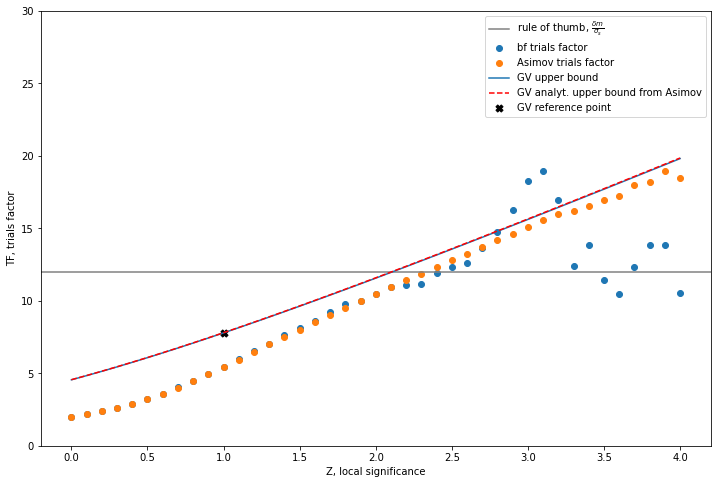

In [45]:
def _plot_tf_cmp_2():
    plt.axhline(thumb_tf, label=r"rule of thumb, $\frac{\delta m}{\sigma_s}$", color="gray")
    plt.scatter(LOCAL_SIG_GRID, tf, label="bf trials factor")
    plt.scatter(LOCAL_SIG_GRID, asimov_tf, label="Asimov trials factor")
    plt.plot(LOCAL_SIG_GRID, gv_tf, label="GV upper bound")
    plt.plot(LOCAL_SIG_GRID, gv_analyt_tf, label="GV analyt. upper bound from Asimov", color="red", ls="--")
    plt.scatter([gv_reference], [avg_euler_number/sig2pval(gv_reference)], label="GV reference point", marker="X", s=50, color="black")
    plt.legend()
    plt.xlabel("Z, local significance")
    plt.ylabel("TF, trials factor")
    plt.ylim(0, 30)

_plot_tf_cmp_2()

# 10. (bonus) 2D scan

For 2D example we prepared a model similar to Hyy but with signal width being scanned together with signal location.

We split the search region into 61x61 points for the location and width correspondingly.

It is quite dense grid, so we only present Asimov set of background samples in this example, and omit the brute force toys.

We start by loading the fitted likelihoods for the 2D model:

In [47]:
fits_2d = {}
with h5py.File("../docs/src/data/Asimov2D/hyy_tutorial.h5") as fin:
    fits_2d["b_loglikes"] = fin["b_loglikes"][...]
    fits_2d["sb_loglikes"] = fin["sb_loglikes"][...]
    fits_2d["sb_params"] = fin["sb_params"][...]
    xs_2d = fin["scan_xs"][...]

When there are 2 parameters scanned (e.g. signal location and width), the significance curves become significance surfaces:

In [48]:
sigs_2d = get_delta_sigs(fits_2d["b_loglikes"], fits_2d["sb_loglikes"], fits_2d["sb_params"][..., 0])

It is still possible to estimate the covariance matrix between points organized into a 2D surface. Each axis of the resulting covariace would contain all points of the 2D grid:

In [49]:
bs_2d = BatchStats2(sigs_2d.shape[0], sigs_2d.shape[1]*sigs_2d.shape[2])
bs_2d.push(sigs_2d.reshape(sigs_2d.shape[0], -1))
corr_2d = bs_2d.get_corr(override_x=np.array(0.))

Let's see the covariance:

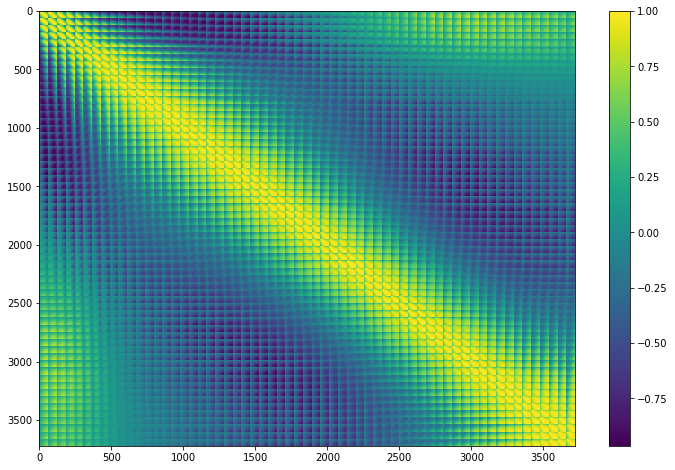

In [50]:
def _show_cov_2d():
    mesh = plt.pcolormesh(corr_2d)
    plt.gca().invert_yaxis()
    plt.colorbar(mesh, ax=plt.gca())
_show_cov_2d()

We can draw samples from the covariance. We need to remember to reshape them back into 2D surfaces, though.

In [51]:
gp_samples_2d = draw_gp_svd(corr_2d, 10_000)  # runs for ~50 sec, don't worry

In [52]:
gp_samples_2d = gp_samples_2d.reshape(-1, *sigs_2d.shape[1:])

From the 10K of significance surfaces we can estimate the TF with GP toys similarly to what we did to set an estimate in 1D case:

In [53]:
p_global_2d = overflows_along_zero_ax(gp_samples_2d, LOCAL_SIG_GRID).mean(axis=0)

In [54]:
asimov_tf_2d = p_global_2d/p_local

For comparison, we suggest to set the Vitells and Gross upper bound on the TF.

For this we would need 2 reference thresholds of local significance at which we will need to compute the average Euler number.

We define the reference thresholds:

In [55]:
vg_reference = LOCAL_SIG_GRID[[7, 10]]
vg_reference

array([0.7, 1. ])

Then we compute the average euler number for each 2D significance surface and take mean:

In [56]:
from sigcorr.tools.euler_number import euler_number_along_zero_ax

avg_euler_num_1 = euler_number_along_zero_ax(gp_samples_2d - vg_reference[0]).mean(axis=0)
avg_euler_num_2 = euler_number_along_zero_ax(gp_samples_2d - vg_reference[1]).mean(axis=0)

vg_euler_number = np.array([avg_euler_num_1, avg_euler_num_2])
vg_euler_number

array([4.6024, 3.8715])

**Exercise 7**

We use `GPEulerNumberPropagator` to propagate the estimated Euler numbers to other values of the local significance.

Similarly to 1D we need to provide the reference points and the average Euler numbers. Please fill in the blanks for this :)

In [57]:
vg_p_global_2d = GPEulerNumberPropagator(<blank>, <blank>).calc(LOCAL_SIG_GRID)

SyntaxError: invalid syntax (326935852.py, line 1)

In [58]:
# answer

vg_p_global_2d = GPEulerNumberPropagator(vg_reference, vg_euler_number).calc(LOCAL_SIG_GRID)

Finally we compute the upper bound on the TF and plot the curves for comparison:

In [59]:
vg_tf_2d = vg_p_global_2d/p_local

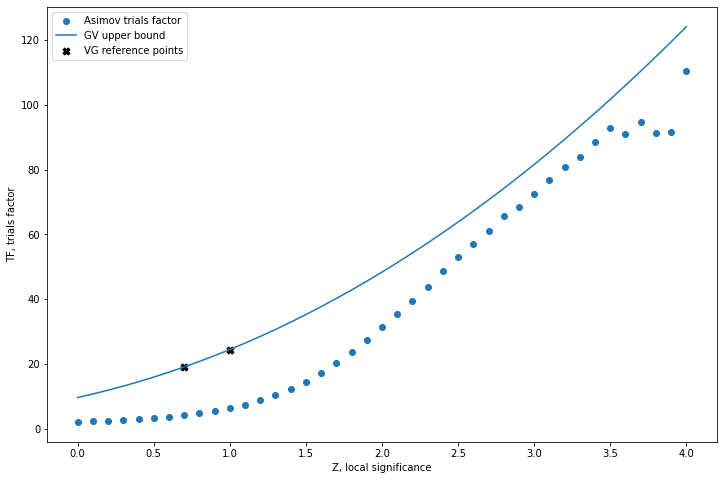

In [60]:
def _plot_tf_cmp_3():
    plt.scatter(LOCAL_SIG_GRID, asimov_tf_2d, label="Asimov trials factor")
    plt.plot(LOCAL_SIG_GRID, vg_tf_2d, label="GV upper bound")
    plt.scatter(vg_reference, [vg_euler_number/sig2pval(vg_reference)], label="VG reference points", marker="X", s=50, color="black")
    plt.legend()
    plt.xlabel("Z, local significance")
    plt.ylabel("TF, trials factor")

_plot_tf_cmp_3()